# Pulse Displayer
In this Notebook the pulse is displayed in the frequency and time domain.


### Import of data and packages

In [1]:
#Import of packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import sys
from scipy.interpolate import interp1d

#Import of the data
df_pulse = pd.read_csv("Data/Pulse.csv", index_col = 0)
df_2DSImap = pd.read_csv("Data/2DSImap.csv", index_col = 0)
df_Phase = pd.read_csv("Data/Phase.csv", index_col = 0)

#Create numpy arrays out of the imported data
#Pulse
f = df_pulse.loc[:, 'f (Hz)'].to_numpy()           #frequency axis pulse
i_f = df_pulse.loc[:, 'spec (norm.)'].to_numpy()   #spectrum (intensity) pulse
phase = df_pulse.loc[:, 'phase (rad)'].to_numpy()  #phase of the pulse
f_center = np.round(np.average(f, weights = i_f), 1) #weighted sum for the computation of the center_frequency

f_shear = df_pulse.loc[:, 'shear (Hz)'].to_numpy() #shear of the 2DSI-map
f_shear = f_shear[0]        

#Phase
f_discrete = df_Phase.loc[:, 'f_discrete (Hz)'].to_numpy()
phase_discrete = df_Phase.loc[:, 'phase_discrete (rad)'].to_numpy()

 ### Elimination of the 0th and 1st order phase
 Due to the discrete frequency axis, the resulting phase can still have a 0th or 1st order phase. As it is not siginificant, is eliminated in the next step:

In [2]:
poly_coefficient = np.polyfit(f_discrete - (f_center * 2), phase_discrete, 10)
poly_coefficient[-1] = 0 #0th order
poly_coefficient[-2] = 0 #1st order

phase_discrete_fit = np.poly1d(poly_coefficient)(f_discrete - (f_center * 2))
phase_f_fit = np.poly1d(poly_coefficient)(f - (f_center))

## Plot of the pulse in the frequency domain:

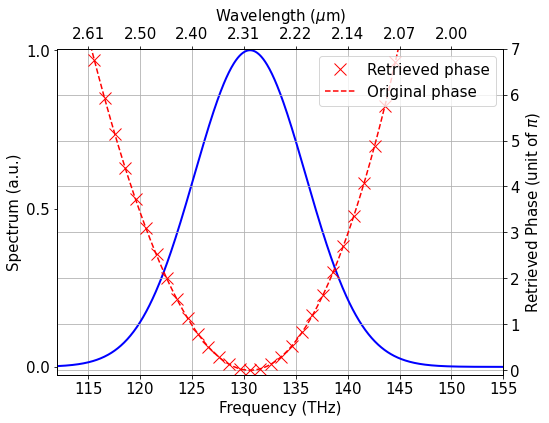

In [3]:
figPulse_f = plt.figure(figsize = (8, 6))
ax_spec= figPulse_f.add_subplot(111)

#Spectrum
ax_spec.plot(f / (10**12), i_f, color = 'blue', linewidth = 2, label="Spectrum") #Real spectrum

#Phase
ax_phase = ax_spec.twinx()
#Retrieved Phase
ax_phase.plot((f_discrete - f_center) / (10**12), phase_discrete_fit / np.pi,'x', label="Retrieved phase",color = 'red',markersize = 12) #measured phase values
#ax_phase.plot(f / (10**12), phase_f_fit)
#Original Phase
ax_phase.plot(f / (10**12), phase / np.pi, '--',color = 'red', label = 'Original phase')  



ax_spec.set_xlim((112, 155))
ax_spec.set_ylim((-0.025, 1.005))
ax_phase.set_ylim((-0.1, 7))


#Wavelength axis
ax1_y = ax_spec.twiny()
#ax1_y.set_xlabel(r"Wavelength ($\mu$m)",fontsize = 38)
def f_tick(x, c): 
    x_ = (3 * 10**8 / (x * 10**12)) * 10**6
    return ["%.2f" % i for i in x_]

ax1_y.set_xbound(ax_spec.get_xbound())
ax1Ticks = ax_spec.get_xticks()
ax1Ticks = ax1Ticks[1:-1]
ax1_y.set_xticks(ax1Ticks)
ax1_y.set_xticklabels(f_tick(ax1Ticks, 3 * 10**8)) 
ax1_y.grid(False)
ax_spec.set_title(r"Wavelength ($\mu$m)", fontsize = 15)


ax_phase.grid()
ax_spec.grid(axis = "x")

#Title,  labels and legend
ax_spec.set_xlabel("Frequency (THz)", fontsize = 15)
ax_spec.set_ylabel("Spectrum (a.u.)", fontsize = 15)
ax_phase.set_ylabel("Retrieved Phase (unit of $\pi$)", fontsize = 15)
ax_phase.legend(loc = "upper right", fontsize = 15)

ax_spec.tick_params(axis = 'both', which = 'major', labelsize = 15)
ax_phase.tick_params(axis = 'both', which = 'major', labelsize = 15)
ax1_y.tick_params(axis = 'both', which = 'major', labelsize = 15)
ax_spec.set_yticks([0,0.5,1])



ax_spec.tick_params(which = 'major', axis='x', direction = 'out')
ax1_y.tick_params(which = 'major', axis='x', direction = 'out')
#ax_spec.tick_params(which = 'major', axis='y', direction = 'out')
ax_phase.tick_params(which = 'major', axis='y', direction = 'out')
    

## Pulse in time domain

### The FFT of the pulse spectrum


In [4]:
def findNearest(array, value):
    #Finds the index of the array element closest to value.
    #array...numpy array
    #value...value
    
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    
    return idx

In [5]:
def pulseTransformer(f, spec, phase, f_center):
    #f...pulse frequency axis (unit: Hz)
    #spec...pulse spectrum (unit: norm.)
    #phase...pulse phase (unit: rad)
    #f_center...center frequency of the pulse (unit: Hz)
    
    #This function transforms the pulse from the frequency to the time domain through a
    #inverse Fourier transform.   
    #Returns:
    #t_ifft...time axis (unit: ps)
    #I_t...intensity over time (unit: norm.)
    #phase_t...phase over time (unit: rad)
    #FWHM...Full Width at Half Maximum of the intensity

    #All frequency components get transformed into THz (10**12) because the time scale
    # of the time axis is picoseconds (10**-12).

    #Time domain specifications
    max_range = 5                                          #2*max range in ps
    dt = 10**-4                                            #resolution in ps

    #Frequency domain requrirements
    P = int(1 / dt)                                        #requrired frequency Span in THz
    n = int(2 * max_range * P)

    #time_axis
    t_ifft = np.linspace(-(n / 2 - 1), n / 2, n)           #numbers from -n/2+1 to n/2 (Works only for even numbers so far)
    t_ifft = t_ifft / P                                    #t_ifft in ps

    #fft frequency axis
    f_fft = np.linspace(-(P / 2), P / 2, n)

    #Shift of Cr:ZnS spectrum to zero
    f_pulse_shift0 =  (f - f_center) / 10**12              #unit THz

    #Interpolation:

    #Finding where the frequency of the spectra starts and ends. 
    #Then gets the index of that position in the new frquency axis
    start_index = findNearest(f_fft, f_pulse_shift0[0])
    end_index = findNearest(f_fft, f_pulse_shift0[-1])

    #Index correction if the found index is has a frequency outside of f_pulse_shift0
    if f_fft[start_index] < f_pulse_shift0[0]:
        start_index = start_index + 1                      #increase by 1 to match interpolation range

    if f_fft[end_index] > f_pulse_shift0[-1]:
        end_index = end_index - 1                          #decrease by 1 to match interpolation range

    #Spectrum interpolation 
    interpol_spec = interp1d(f_pulse_shift0, spec, kind = 'cubic')
    
    spec_f_fft = np.zeros(np.size(f_fft))                  #Outside of the interpolation range the specturm is 0
    spec_f_fft[start_index : end_index] = interpol_spec(f_fft[start_index : end_index]) 


    #Phase interpolation
    interpol_phase = interp1d(f_pulse_shift0, phase)

    phase_fft = np.zeros(np.shape(f_fft))                  #Outside of the interpolation range the phase is 0
    phase_fft[start_index : end_index] = interpol_phase(f_fft[start_index : end_index]) 
    
    #Inverse Fourier transform:
    E_fft = np.sqrt(spec_f_fft) * np.exp(-1j * phase_fft) #The E-field over frequency shifted to 0 Hz
    
    #The inverse Fourier transform:
    E_ifft = np.fft.ifft(E_fft)
    
    #Getting the two halfs:
    E_t_1 = E_ifft[0:int(n / 2)]
    E_t_2 = E_ifft[int(n / 2):n]
    
    #Creation of the alternating mask to compensate for the FFT-algorithm ambiguity.
    num_error_mask = np.empty(np.size(t_ifft))
    num_error_mask[::2] = 1                               #every even index is 1
    num_error_mask[1::2] = -1                             #every uneven index is -1

    #Calculation of the temporal phase:
    phase_t = np.unwrap(np.angle(np.concatenate((E_t_2, E_t_1)) * num_error_mask))

    #Elimination of the 0th order:
    index_shift_p0 = np.argwhere(t_ifft == 0)[0][0]
    phase_t = phase_t - phase_t[index_shift_p0]

    #E-field over time:
    E_ifft = np.concatenate((E_t_2, E_t_1))* np.exp(1j * 2*np.pi * f_center * t_ifft) * num_error_mask
    
    #Intensity over time:
    I_t = abs(E_ifft)**2
    I_t = I_t/np.max(I_t)

    #Calculation of the Full Width at Half Maximum (FWHM)
    maskFWHM = I_t - 0.5 >= 0
    FWHM = t_ifft[maskFWHM][-1] - t_ifft[maskFWHM][0]
    
    return t_ifft, I_t, phase_t, FWHM

### Evaluation of the pulses

In [6]:
#2DSI-Retrieved Data:
(t_ifft, I_t_2DSI, phase_t_2DSI, FWHM_2DSI) = pulseTransformer(f, i_f, phase_f_fit, f_center)

#Computationally Created Data: (from 2DSI_Map_Creator)
(t_ifft, I_t_Comp, phase_t_Comp, FWHM_Comp) = pulseTransformer(f, i_f, phase, f_center)

## Plot of the pulse in the time domain:

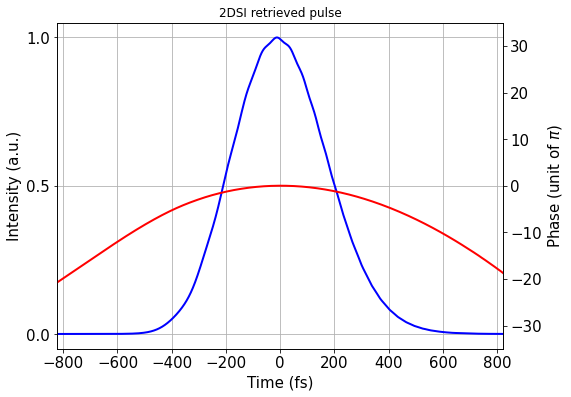

In [7]:
figPulse_t = plt.figure(figsize = (8, 6))
ax = figPulse_t.add_subplot(111)

#Intensity over time axis
ax.plot(t_ifft * 10**3, I_t_2DSI, color = 'blue', linewidth = 2)
ax.set_yticks([0, 0.5, 1])

#Phase axis
ax1 = ax.twinx()
ax1.plot(t_ifft * 10**3, - phase_t_2DSI / np.pi, linewidth = 2, color ='red')

#title and labels
ax.set_xlabel("Time (fs)", fontsize = 15)
ax.set_ylabel("Intensity (a.u.)", fontsize = 15)
ax1.set_ylabel('Phase (unit of $\pi$)', fontsize = 15)
ax.set_title("2DSI retrieved pulse")
ax.tick_params(axis = 'both', which = 'major', labelsize = 15)
ax1.tick_params(axis = 'both', which = 'major', labelsize = 15)


#Limits
ax.set_xlim((-2 * FWHM_2DSI * 1000, 2 * FWHM_2DSI * 1000)) #automatic scaling of the time-axis from -2*FWHM to 2*FWHM
ax1.set_ylim((-35, 35))

#Grids
ax.grid()

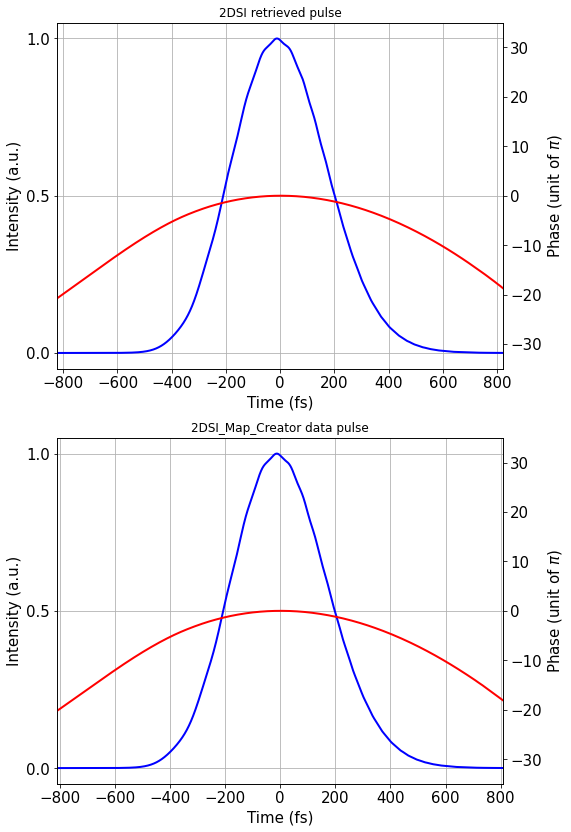

In [8]:
figPulse_t = plt.figure(figsize = (8, 14))
ax = figPulse_t.add_subplot(211)

#Intensity over time axis
ax.plot(t_ifft * 10**3, I_t_2DSI, color = 'blue', linewidth = 2)
ax.set_yticks([0, 0.5, 1])

#Phase axis
ax1 = ax.twinx()
ax1.plot(t_ifft * 10**3, -phase_t_2DSI / np.pi, linewidth = 2, color ='red')

#title and labels
ax.set_xlabel("Time (fs)", fontsize = 15)
ax.set_ylabel("Intensity (a.u.)", fontsize = 15)
ax1.set_ylabel('Phase (unit of $\pi$)', fontsize = 15)
ax.set_title("2DSI retrieved pulse")
ax.tick_params(axis = 'both', which = 'major', labelsize = 15)
ax1.tick_params(axis = 'both', which = 'major', labelsize = 15)


#Limits
ax.set_xlim((-2 * FWHM_2DSI * 1000, 2 * FWHM_2DSI * 1000)) #automatic scaling of the time-axis from -2*FWHM to 2*FWHM
ax1.set_ylim((-35, 35))

#Grids
ax.grid()

ax = figPulse_t.add_subplot(212)

#Intensity over time axis
ax.plot(t_ifft * 10**3, I_t_Comp, color = 'blue', linewidth = 2)
ax.set_yticks([0, 0.5, 1])

#Phase axis
ax1 = ax.twinx()
ax1.plot(t_ifft * 10**3, -phase_t_Comp / np.pi, linewidth = 2, color ='red')

#title and labels
ax.set_xlabel("Time (fs)", fontsize = 15)
ax.set_ylabel("Intensity (a.u.)", fontsize = 15)
ax1.set_ylabel('Phase (unit of $\pi$)', fontsize = 15)
ax.set_title("2DSI_Map_Creator data pulse")
ax.tick_params(axis = 'both', which = 'major', labelsize = 15)
ax1.tick_params(axis = 'both', which = 'major', labelsize = 15)


#Limits
ax.set_xlim((-2 * FWHM_Comp * 1000, 2 * FWHM_Comp * 1000)) #automatic scaling of the time-axis from -2*FWHM to 2*FWHM
ax1.set_ylim((-35, 35))

#Grids
ax.grid()

#### 